In [3]:
import numpy as np
import torchvision.datasets as datasets
import torch
from data_cleaning import *
import time
import matplotlib.pyplot as plt

In [374]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

size_dataset = mnist_trainset.test_data.shape[0]
v_data = mnist_trainset.train_data.reshape(size_dataset, -1).float()
v_data.size()

/home/karelgeraedts/Documents/uni/Master_Theses/code/Renormalization-Group-Bialek/.venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/karelgeraedts/Documents/uni/Master_Theses/code/Renormalization-Group-Bialek/.venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 784])

In [4]:
def normalize_data(v_data):
    # Compute standard deviations
    stds = torch.std(v_data, dim=0)

    # Find features with std = 0
    features_to_mask = torch.argwhere(stds == 0).unique()

    # Create mask
    mask = torch.ones(v_data.size()[1], dtype=bool)
    mask[features_to_mask] = False

    # Mask these features
    v_data = v_data[:, mask]
    
    # Return normalized data
    return (v_data - torch.mean(v_data, dim=0)) / torch.std(v_data, dim=0)

v_data = normalize_data(v_data)
v_data.size()

NameError: name 'v_data' is not defined

In [588]:
# Load Ebo's dataset
f = "data/2d_Ising_metropolis_L=16,T=3.npy"
v_data = read_input(f)
v_data[v_data == - 1] = 0
v_data = torch.tensor(v_data).float()
v_data.size(), v_data.type()

(torch.Size([16384, 256]), 'torch.FloatTensor')

In [589]:
# Transform the data from binary values to probabilities

# Compute average probability of visible spins being 1
v_prob_spin_up = v_data.mean(dim=0)
v_prob_spin_down = 1 - v_prob_spin_up

# Create array of same shape as dataset. We can then mask this.
v_prob_spin_up = v_prob_spin_up.repeat(len(v_data), 1)
v_prob_spin_down = v_prob_spin_down.repeat(len(v_data), 1)

# Use the dataset as a mask te create ndarray with P(v=1) and P(v=0)
mask_spin_up = v_data.bool()
mask_spin_down = (1 - v_data).bool()
v_data_probs_spin_up = torch.where(mask_spin_up, v_prob_spin_up, 0)
v_data_probs_spin_down = torch.where(mask_spin_down, v_prob_spin_down, 0)

# Now add them together to get dataset in terms of probabilities
v_data_probs = v_data_probs_spin_down + v_data_probs_spin_up
v_data_probs.shape

torch.Size([16384, 256])

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 

class RBM(nn.Module):

    def __init__(self, n_visible, n_hidden, CD_depth):
        super(RBM, self).__init__()
        # User input
        self.CD_depth = CD_depth

        # Model Parameters
        # NOTE: Set requires_grad=False because the weights are updated using CD not with backpropagation
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 1e-2, requires_grad=False)
        self.v_bias = nn.Parameter(torch.zeros(n_visible), requires_grad=False)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden), requires_grad=False)

    def sample_from_p(self, p):
        """
        Sample a binary value from the probability distribution p. p is a 1d array with each value i corresponding
        to the probability that variable i is equal to 1. Naturally 1-p is the probablity of 0 then.

        Parameters:
            p - probability distribution

        Return:
            sample - the binary sample drawn from p
        """
        # uniform_random = torch.rand(p.size)
        # sample = F.relu(torch.sign(p  - uniform_random))
        # return sample
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = torch.sigmoid(v @ self.W + self.h_bias)
        return self.sample_from_p(p_h), p_h

    def h_to_v(self, h):
        p_v = torch.sigmoid(h @ self.W.t() + self.v_bias)
        return self.sample_from_p(p_v), p_v

    def forward(self, v_states, h_probs):
        # Return prediction (v_i * h_j)

        # NOTE: The prediction is the joint probability of the two layers firing.
        return (v_states.T @ h_probs)


    def create_CD_reconstructions(self, h_states, h_probs, k):
        # NOTE: When creating the labels we do not want torch to update the gradients.
        # NOTE: For the learning I am using the binary values. Check whether learning is quicker with binary values or probabilities instead?
        with torch.no_grad():
            hk_states = h_states
            hk_probs = h_probs
            len_data_batch = h_states.size()[0]

            # Perform k CD steps
            for _ in range(k-1):
                vk_states, vk_probs = self.h_to_v(hk_states)
                hk_states, hk_probs = self.v_to_h(vk_probs)

            # Last update is slightly different
            vk_states, vk_probs = self.h_to_v(hk_probs) #NOTE: Here we use the hidden probabilities instead (This should avoid unnecessary sampling noise)
            kh_states, hk_probs = self.v_to_h(vk_probs)

            # CD visible and hidden state reconstructions
            h_reconstruction = hk_probs
            v_reconstruction = vk_probs
            vh_reconstruction = (vk_probs.T @ hk_probs)# / len_data_batch

            # Return CD reconstructions
            return vh_reconstruction, v_reconstruction, h_reconstruction

In [6]:
from torch.optim import Optimizer

class RBMOptimizer(Optimizer):
    def __init__(self, rbm, learning_rate=0.01, weight_decay=0, momentum=0):
        defaults = dict(learning_rate=learning_rate, weight_decay=weight_decay, momentum=momentum)
        super().__init__(rbm.parameters(), defaults)
        self.rbm = rbm

    def step(self, v_bias_update, h_bias_update, vh_weight_update):
        for group in self.param_groups:
            # Learning params
            learning_rate = group["learning_rate"]
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]

            # Update weights
            self.rbm.v_bias += learning_rate * v_bias_update
            self.rbm.h_bias += learning_rate * h_bias_update
            self.rbm.W += learning_rate * vh_weight_update #- weight_decay * torch.sign(self.rbm.W)

In [62]:
# RBM parrams
#n_visible = v_data.shape[1]
n_hidden = 64
CD_depth = 5

# Weight update params
learning_rate = 0.1
weight_decay = 0.1
momentum = 0

# Learning params
epochs = 1000
batch_size = 3200

# Normalize data s.t. N(0, 1)
#v_data = normalize_data(v_data)

# Testing the model on a simple dataset with 5 spins
######################################################################################################################################
all_states = np.arange(2**5)
all_states = [np.binary_repr(x, 5) for x in all_states]
v_data_empty = np.empty(shape=(32, 5))

for i, binary_string in enumerate(all_states):
    v_data_empty[i] = np.array([int(char) for char in binary_string], dtype=np.float16)

all_states = torch.tensor(v_data_empty, dtype=torch.float)

v_probs_spin_up = all_states.mean(dim=0)

v_probs_spin_up = v_probs_spin_up.repeat(len(all_states), 1)
all_states = all_states.bool()

all_states_probs = torch.where(all_states, v_probs_spin_up, 0)
all_states_probs[all_states_probs == 0.0] = 0.5 #NOTE: this will not work if the visible units have different P(silence)

v_data = np.repeat(all_states_probs, 100, axis=0)

n_visible = 5
n_hidden = 5
batch_size = 320
epochs = 1000
CD_depth = 1
learning_rate = 0.1
######################################################################################################################################

# Create RBM layer
rbm = RBM(n_visible, n_hidden, CD_depth)

# Optimizer
optimizer = RBMOptimizer(rbm, learning_rate=learning_rate)

# Things to keep track of
expression_to_update_weights_ = []

# Put data in a torch.DataLoader
v_dataloader = torch.utils.data.DataLoader(v_data, batch_size=batch_size, shuffle=True, num_workers=0)

t1 = time.time()
total_time = 0
for epoch in range(epochs):
    # Initialize errors (per epoch) at zero
    v_recon_error = torch.tensor(0, dtype=float)
    h_recon_error = torch.tensor(0, dtype=float)
    vh_recon_error = torch.tensor(0, dtype=float)

    # Start batch training
    # for v_probs_batch in v_dataloader:
    # NOTE: Adding this seems to slow down the computation. Probably because computation is not sent to the GPU yet. 
    # NOTE: For now that means we just train by computing gradient over the entire d    taset. I.e. no SGD.

    v_probs_batch = v_data
    
    # Forward statistics
    h_states_batch, h_probs_batch = rbm.v_to_h(v_probs_batch)
    vh_batch = rbm(v_probs_batch, h_probs_batch) #NOTE: Joint-probability distribution P(v, h)   


    # Reconstruction statistics (Computed using Contrastive Divergence)
    vh_recon, v_probs_recon, h_probs_recon = rbm.create_CD_reconstructions(h_states_batch, h_probs_batch, CD_depth)

    # Compute weight updates
    t2 = time.time()
    v_bias_update = (v_probs_batch - v_probs_recon).mean(axis=0)
    h_bias_update = (h_states_batch - h_probs_recon).mean(axis=0)
    vh_weight_update = (vh_batch - vh_recon) / len(v_probs_batch)
    total_time += time.time() - t2  

    # Update weights    
    optimizer.step(v_bias_update, h_bias_update, vh_weight_update)
    
    # Compute loss statistics
    v_recon_error += torch.sum((v_probs_batch - v_probs_recon) ** 2, dim=(0,1))
    h_recon_error += torch.sum((h_states_batch - h_probs_recon) ** 2, dim=(0,1))
    vh_recon_error += torch.sum((vh_batch - vh_recon) ** 2, dim=(0,1))

    # Store losses together
    loss = [v_recon_error, h_recon_error, vh_recon_error]

    # Print loss
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Reconstructions errors: {}'.format(epoch+1, epochs, loss))

(time.time() - t1) / epochs, total_time / epochs

Epoch [1/1000], Reconstructions errors: [tensor(0.0744, dtype=torch.float64), tensor(4000.7639, dtype=torch.float64), tensor(299.8947, dtype=torch.float64)]
Epoch [2/1000], Reconstructions errors: [tensor(0.0662, dtype=torch.float64), tensor(3999.6318, dtype=torch.float64), tensor(266.6436, dtype=torch.float64)]
Epoch [3/1000], Reconstructions errors: [tensor(0.0589, dtype=torch.float64), tensor(4000.4441, dtype=torch.float64), tensor(237.4156, dtype=torch.float64)]
Epoch [4/1000], Reconstructions errors: [tensor(0.0524, dtype=torch.float64), tensor(3999.6799, dtype=torch.float64), tensor(211.1206, dtype=torch.float64)]
Epoch [5/1000], Reconstructions errors: [tensor(0.0467, dtype=torch.float64), tensor(4000.6587, dtype=torch.float64), tensor(188.1020, dtype=torch.float64)]
Epoch [6/1000], Reconstructions errors: [tensor(0.0415, dtype=torch.float64), tensor(4000.0557, dtype=torch.float64), tensor(167.0372, dtype=torch.float64)]
Epoch [7/1000], Reconstructions errors: [tensor(0.0369, dt

(0.0025717484951019286, 0.00013389897346496583)

In [372]:
# Forward statistics
_, h_probs = rbm.v_to_h(v_data)
vh = rbm(v_data, h_probs) #NOTE: Joint-probability distribution P(v, h)   

# Reconstruction statistics (Computed using Contrastive Divergence)

for k in range(1, 2000, 50):
    _, v_probs_recon, _ = rbm.create_CD_reconstructions(h_probs, k)

    print(f"CD_steps = {k} || reconstruction error = {torch.sum((v_data - v_probs_recon) ** 2, dim=(0,1))}")

CD_steps = 1 || reconstruction error = 0.019892249256372452
CD_steps = 51 || reconstruction error = 0.020168399438261986
CD_steps = 101 || reconstruction error = 0.020168399438261986
CD_steps = 151 || reconstruction error = 0.020168399438261986
CD_steps = 201 || reconstruction error = 0.020168399438261986
CD_steps = 251 || reconstruction error = 0.020168399438261986
CD_steps = 301 || reconstruction error = 0.020168399438261986
CD_steps = 351 || reconstruction error = 0.020168399438261986
CD_steps = 401 || reconstruction error = 0.020168399438261986
CD_steps = 451 || reconstruction error = 0.020168399438261986
CD_steps = 501 || reconstruction error = 0.020168399438261986
CD_steps = 551 || reconstruction error = 0.020168399438261986
CD_steps = 601 || reconstruction error = 0.020168399438261986
CD_steps = 651 || reconstruction error = 0.020168399438261986
CD_steps = 701 || reconstruction error = 0.020168399438261986
CD_steps = 751 || reconstruction error = 0.020168399438261986
CD_steps = 

torch.Size([256, 64])
torch.Size([256])
torch.Size([64])


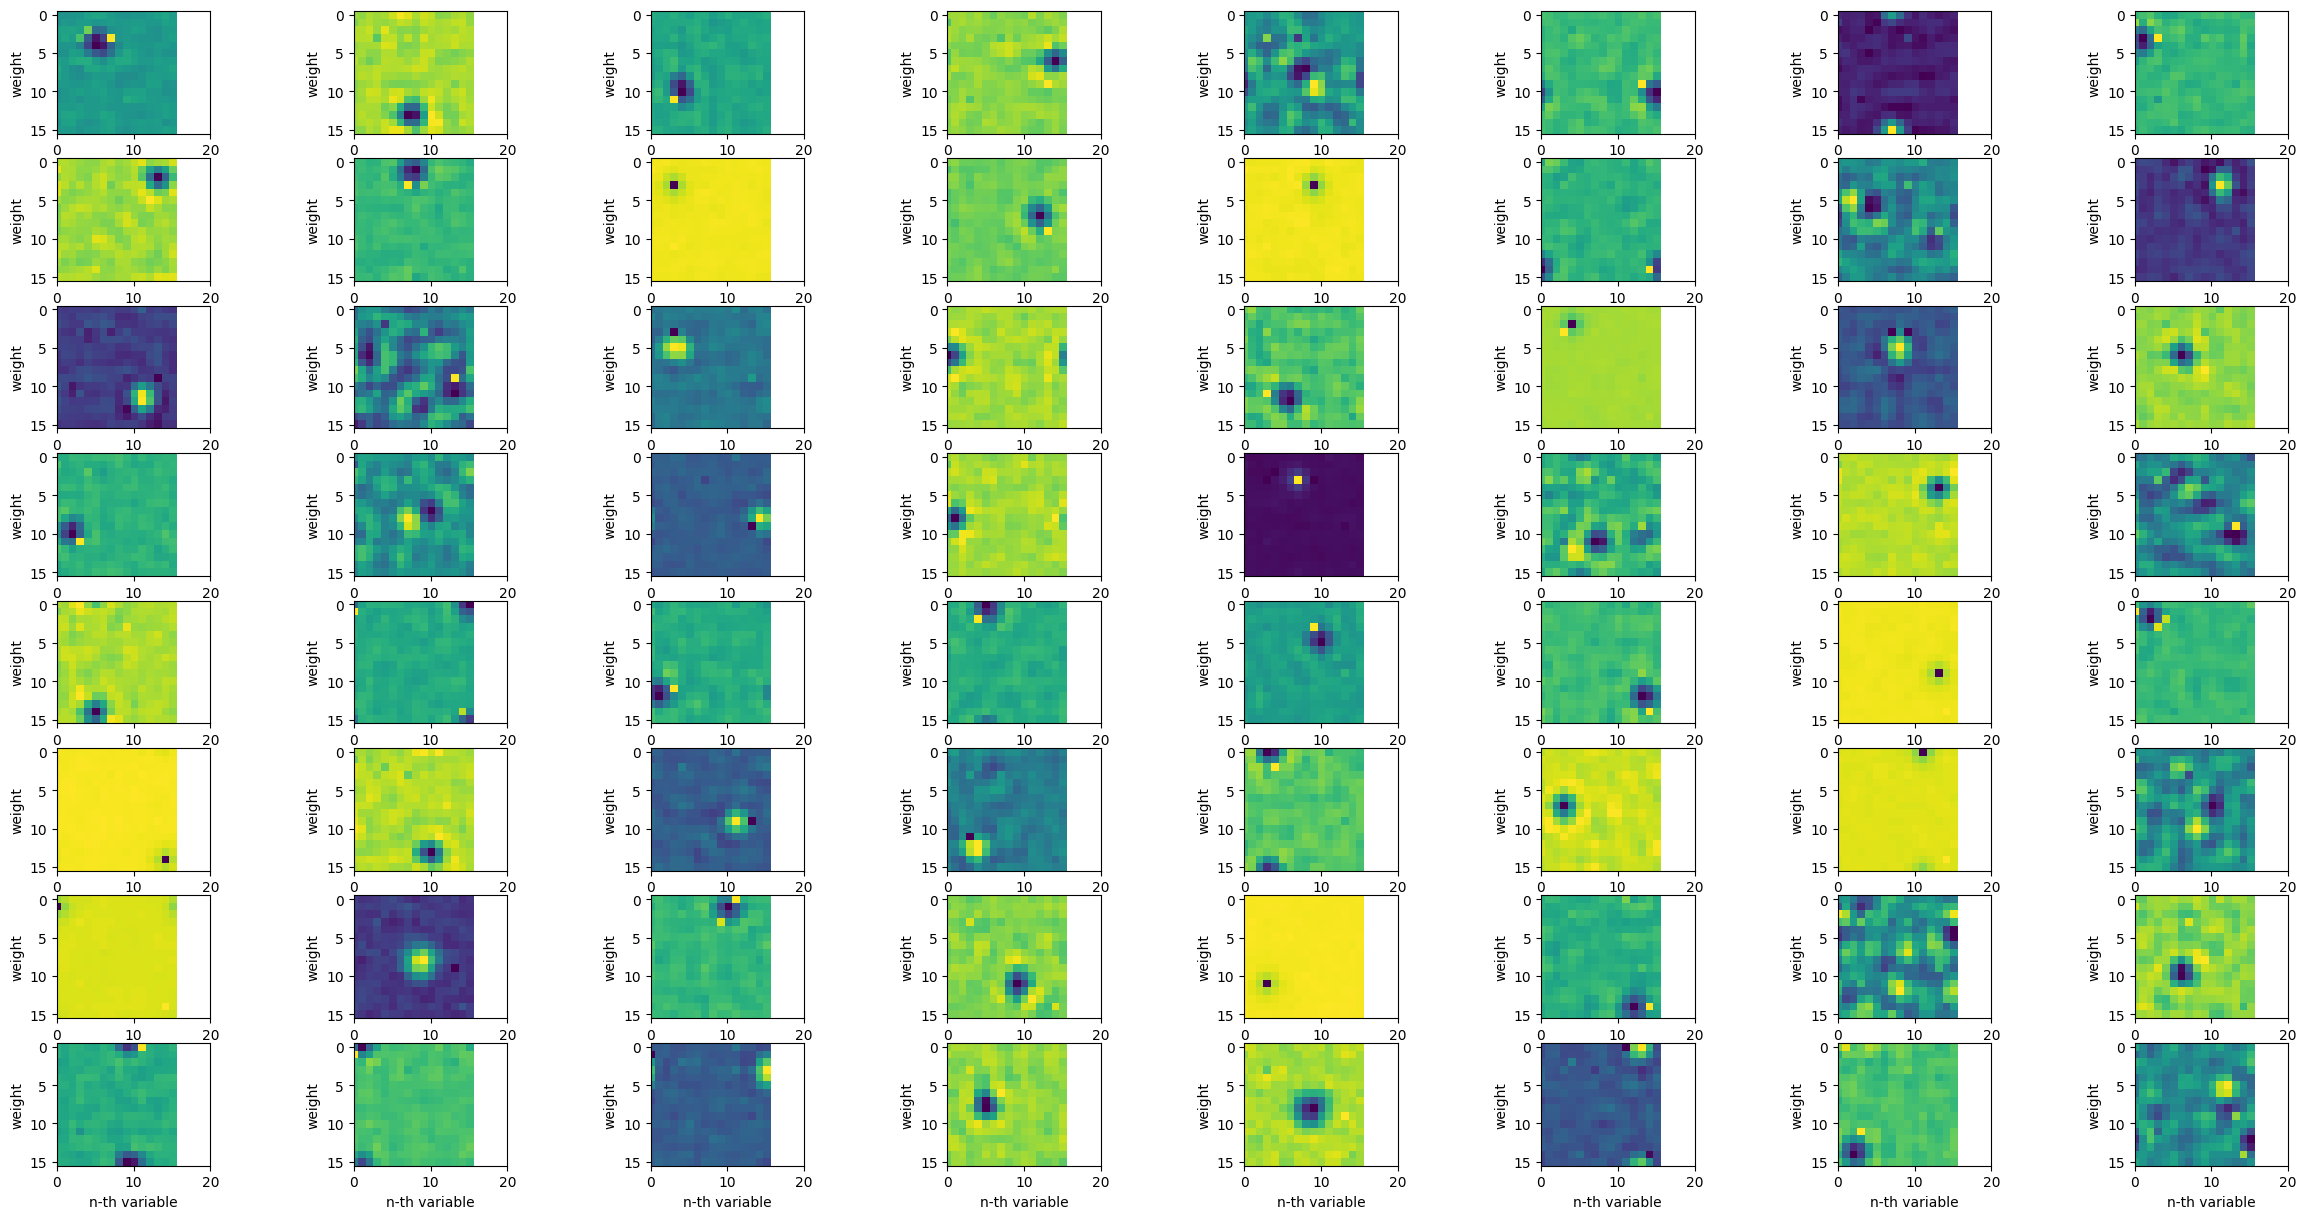

In [596]:
for param in rbm.parameters():
    print(param.size())

W = rbm.parameters().__next__()
v_bias = rbm.parameters().__next__()
h_bias = rbm.parameters().__next__()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8, figsize=(30, 15))
axs = axs.ravel()

for i, receptive_field in enumerate(W.T):
    axs[i].imshow(receptive_field.reshape(16, 16))
    axs[i].set_xlabel("n-th variable")
    axs[i].set_ylabel("weight")
    axs[i].set_xlim(0, 20)

plt.show()

In [558]:
rbm.W, rbm.v_bias, rbm.h_bias

(Parameter containing:
 tensor([[ 0.0027, -0.0033,  0.0071, -0.0108, -0.0089],
         [ 0.0111,  0.0089, -0.0163,  0.0145,  0.0066],
         [-0.0032, -0.0113,  0.0012,  0.0039,  0.0080],
         [ 0.0060, -0.0061, -0.0164, -0.0060, -0.0134],
         [ 0.0015,  0.0081,  0.0053, -0.0026, -0.0007]]),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.]),
 Parameter containing:
 tensor([0., 0., 0., 0., 0.]))

tensor([[1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.]])
Partition function Z = 63.60700988769531


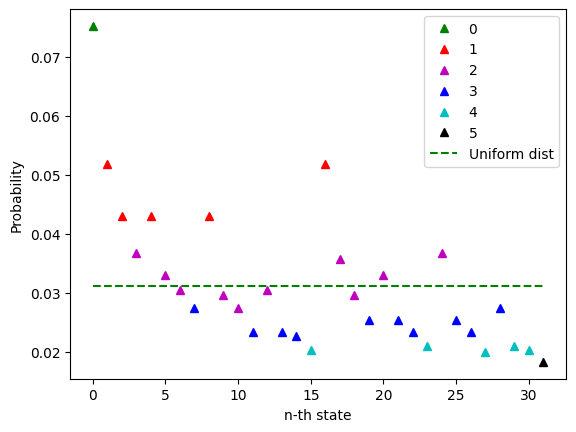

(tensor(39.9931), tensor(0.0045))

In [146]:
def create_all_states(n):
    all_states = np.arange(2**n)
    all_states = [np.binary_repr(x, n) for x in all_states]
    v_data_empty = np.empty(shape=(2**n, n))

    for i, binary_string in enumerate(all_states):
        v_data_empty[i] = np.array([int(char) for char in binary_string], dtype=np.float16)

    all_states = torch.tensor(v_data_empty, dtype=torch.float)
    return all_states

n_visible = 5
n_hidden = 20
all_states = create_all_states(n_visible)
all_states_h = create_all_states(n_hidden)

# Compute energy
def energy(v, h, W, v_bias, h_bias):
    # NOTE: The weight array has as index W_vh. 
    W = -(v @ W @ h.T)
    return  W - (v @ v_bias).repeat(len(W), 1).T - (h @ h_bias)

def compute_model_statistics(weights, v_bias, h_bias, verbose=False):
    # Compute energy for each state
    energy_all_states = np.exp(energy(all_states, all_states, weights, v_bias, h_bias))

    # As a test compute the unnormalized probability of P(v={0,0,0,0,0})
    if verbose == True:
        print("Test:")
        print("############################################")

        v = all_states[1]
        print(f"v = {v}")

        energies = energy(v, all_states, weights, v_bias, h_bias)

        print(f"\nIf v = {v} then the energies can be computed by adding different component of the hidden state biases.")

        print("\nRBM weights:")
        print(f"- Hidden biases = {h_bias.numpy()}")
        print(f"- Visible bias 5 = {v_bias.numpy()[4]}")
        print(f"- Weights for visible spin 5 = {weights[4]}")

        print("\nFor each state h we compute the energy and print the pair (energy, state)\n")

        #expressions = ["-w_55 - b_5 - c_5",]
        expressions = list(range(32))

        expressions[1:5] = ["-w_55 - b5 - c5", "-w_54 - b5 - c4", "-w_55 - w_54 - b5 - c5 - c4", "-w_53 - b5 - c3", "-w_55 - w_53 - b5 - c5 - c3"]

        for i, e in enumerate(energies.T):
            print(f"Expression = {expressions[i]}\nEnergy = {e.numpy()} || state = {all_states[i].numpy()}\n")

    # Compute partition function
    Z = torch.sum(energy_all_states)
    print(f"Partition function Z = {Z}")

    # Compute model distributions
    v_prob_model = torch.sum(energy_all_states, dim=0) / Z
    vh_prob_model = energy_all_states / Z

    return vh_prob_model, v_prob_model

# Save trained weights
W = rbm.W
v_bias = rbm.v_bias
h_bias = rbm.h_bias

def generate_matrix(n):
    matrix = np.zeros((n, n))
    for i in range(n):
        matrix[i, i] = 1
        if i + 1 < n:
            matrix[i, i + 1] = 1
            matrix[i + 1, i] = 1
    return matrix

# Lets test how P(v) looks like for some custom values of the weights
v_bias = 1 * torch.ones(5, dtype=torch.float)
h_bias = 1 * torch.zeros(5, dtype=torch.float)
W = torch.tensor(np.identity(5), dtype=torch.float)
W[:, 0] = 1
W = torch.tensor(generate_matrix(5), dtype=torch.float)

print(W)

vh_prob_model, v_prob_model = compute_model_statistics(W, v_bias, h_bias)

# Plot P(v)_model
import matplotlib.pyplot as plt

colors = ["g", "r", "m", "b", "c", "k"]
sorted_states = [[], [], [], [], [], []]

for i, state in enumerate(all_states):
    color_idx = len(state[state == 1])

    sorted_states[color_idx].append(i)

for i, sorted in enumerate(sorted_states):
    plt.plot(sorted, v_prob_model[sorted], f"{colors[i]}^", label=f"{i}")

plt.plot(np.arange(32), [1/32 for i in range(32)], "g--", label="Uniform dist")
plt.xlabel("n-th state")
plt.ylabel("Probability")
plt.legend()
plt.show()

h_states, h_probs = rbm.v_to_h(all_states)
vh_recon, v_recon, h_recon = rbm.create_CD_reconstructions(h_probs, h_states, k=1)

((v_recon - all_states) ** 2).sum(), (((1/32) - v_prob_model) ** 2).sum()

In [72]:
def energy(v, h, W, v_bias, h_bias):
    # NOTE: The weight array has as index W_vh. 
    W = -(v @ W @ h.T)
    return  W - (v @ v_bias).repeat(len(W), 1).T - (h @ h_bias)

energy_all_states = np.exp(energy(all_states, all_states, rbm.W, rbm.v_bias, rbm.h_bias))

Z = torch.sum(energy_all_states)
print(f"Partition function Z = {Z}")

# Compute model distributions
v_prob_model = torch.sum(energy_all_states, dim=0) / Z

v_prob_model

Partition function Z = 998.9833374023438


tensor([0.0322, 0.0322, 0.0307, 0.0307, 0.0307, 0.0307, 0.0293, 0.0293, 0.0329,
        0.0329, 0.0314, 0.0314, 0.0313, 0.0314, 0.0299, 0.0299, 0.0326, 0.0326,
        0.0311, 0.0311, 0.0310, 0.0310, 0.0296, 0.0296, 0.0333, 0.0333, 0.0318,
        0.0318, 0.0317, 0.0317, 0.0303, 0.0303])

In [371]:
torch.sum((v_prob_model - (1/32)) ** 2), max(v_prob_model), (max(v_prob_model) - (1/32))**2

(tensor(0.3408), tensor(0.5631), tensor(0.2829))

tensor(-0.0145) tensor(0.0151)


ValueError: cannot reshape array of size 5 into shape (16,16)

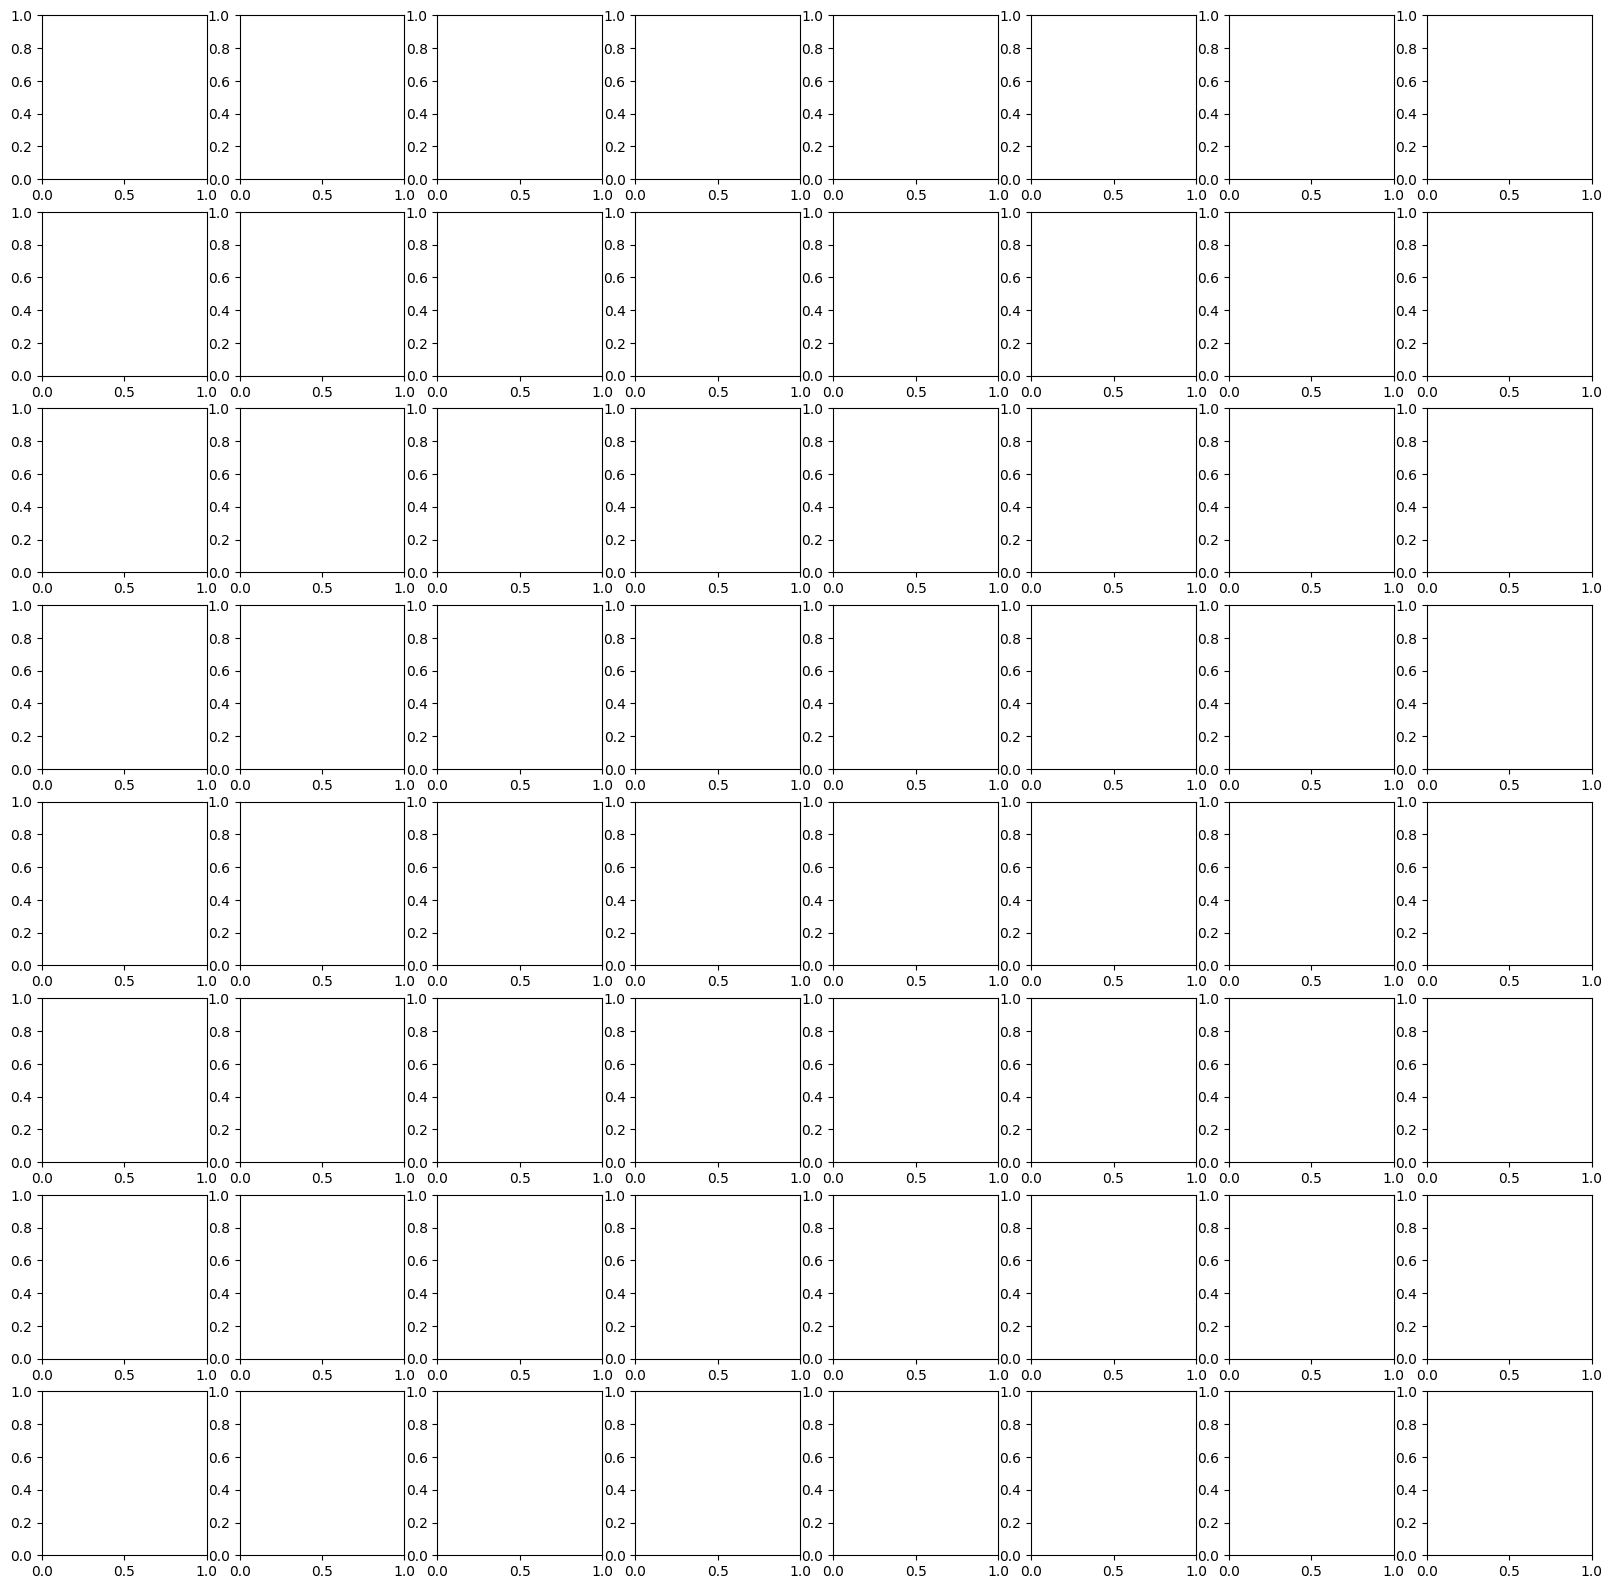

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

params = rbm.parameters()
W = list(params)[0]

# Create a figure with 8 rows and 8 columns of subplots
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

# Flatten the axes array to make it 1-dimensional
axes = axes.ravel()

# Create an empty mappable object
print(W.min(), W.max())
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=W.min(), vmax=W.max()))
sm._A = []

for i, hidden in enumerate(W.T):
    # Reshape weights
    hidden = hidden.numpy().reshape(16, 16)

    # Select the current subplot
    ax = axes[i]

    # Plot the heatmap of the weights on the current subplot
    sns.heatmap(hidden, ax=ax, cmap='YlGnBu', cbar=False, xticklabels=False, yticklabels=False)

    # Remove the axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Add the colorbar to the figure
cbar = plt.colorbar(sm, ax=axes, fraction=0.046, pad=0.04)

# Display the figure
plt.show()

In [431]:
import torch

arr = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
mask = torch.tensor([True, False, True, False, True, False, True, False, True, False], dtype=torch.bool)
default_value = 0
result = torch.where(mask, arr, default_value)
print(result) # tensor([1, 0, 3, 0, 5, 0, 7, 0, 9, 0])


tensor([1, 0, 3, 0, 5, 0, 7, 0, 9, 0])
